In [1]:
import torch
from targets.density_estimation_target import * 
from models_dif import DIFDensityEstimator

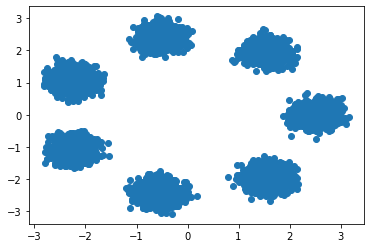

In [2]:
target = Orbits()
target_samples = target.sample(10000)
plt.scatter(target_samples[:,0].numpy(),target_samples[:,1].numpy())

In [34]:
import torch
from torch import nn
from torch.distributions import Categorical
from tqdm import tqdm

from models_dif.multivariate_normal_reference import MultivariateNormalReference
from models_dif.location_scale_flow import LocationScaleFlow
from models_dif.softmax_weight import SoftmaxWeight

import torch
from torch import nn

class LocationScaleFlow(nn.Module):
    def __init__(self, K, p):
        super().__init__()
        self.K = K
        self.p = p

        self.m = nn.Parameter(torch.randn(self.K, self.p))
        self.log_s = nn.Parameter(torch.zeros(self.K, self.p))

    def backward(self, z):
        desired_size = list(z.shape)
        desired_size.insert(-1, self.K)
        Z = z.unsqueeze(-2).expand(desired_size)
        return Z * torch.exp(self.log_s).expand_as(Z) + self.m.expand_as(Z)

    def forward(self, x):
        desired_size = list(x.shape)
        desired_size.insert(-1, self.K)
        X = x.unsqueeze(-2).expand(desired_size)
        return (X-self.m.expand_as(X))/torch.exp(self.log_s).expand_as(X)

    def log_det_J(self,x):
        return -self.log_s.sum(-1)
import torch
from torch import nn

class MultivariateNormalReference(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.mean = torch.zeros(self.p)
        self.cov = torch.eye(self.p)
        self.distribution = torch.distributions.MultivariateNormal(self.mean, self.cov)

    def estimate_moments(self, samples):
        self.mean = torch.mean(samples, dim = 0)
        cov = torch.cov(samples.T)
        self.cov = (cov + cov.T)/2
        self.distribution = torch.distributions.MultivariateNormal(self.mean, self.cov)

    def sample(self, num_samples):
        return self.distribution.sample([num_samples])
        #return torch.randn([num_samples, self.p])

    def log_density(self, z):
        mean = self.mean.to(z.device)
        cov = self.cov.to(z.device)
        self.distribution = torch.distributions.MultivariateNormal(mean,cov)
        return self.distribution.log_prob(z)
        #return -torch.sum(torch.square(z)/2, dim = -1) - torch.log(torch.tensor([2*torch.pi], device = z.device))*self.p/2

import torch
from torch import nn
import torch.nn.functional as F

class ConstantWeight(nn.Module):
    def __init__(self, K, p):
        super(ConstantWeight, self).__init__()
        self.K = K
        self.p = p
        self.log_weight = torch.log(torch.ones(self.K)/self.K)

    def log_prob(self,z):
        shape = z.shape[:-1]
        temp = self.log_weight - torch.logsumexp(self.log_weight, dim = -1)
        return torch.reshape(temp, shape)

class SoftmaxWeight(nn.Module):
    def __init__(self, K, p, hidden_dimensions =[]):
        super().__init__()
        self.K = K
        self.p = p
        self.network_dimensions = [self.p] + hidden_dimensions + [self.K]
        network = []
        for h0, h1 in zip(self.network_dimensions, self.network_dimensions[1:]):
            network.extend([nn.Linear(h0, h1),nn.Tanh(),])
        network.pop()
        self.f = nn.Sequential(*network)

    def log_prob(self, z):
        unormalized_log_w = self.f.forward(z)
        return unormalized_log_w - torch.logsumexp(unormalized_log_w, dim=-1, keepdim=True)

class ConvNetWeight(nn.Module):
    def __init__(self, K, p):
        super(ConvNetWeight, self).__init__()
        self.K = K
        self.p = p
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, K)

        # x represents our data
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def log_prob(self, z):
        old_shape = list(z.shape)
        if len(old_shape) == 3:
            shape = [old_shape[0]*old_shape[1]]
        elif len(old_shape) == 2:
            shape = [old_shape[0]]
        shape.append(1)
        shape.append(28)
        shape.append(28)
        old_shape[-1] = self.K
        unormalized_log_w = self.forward(z.view(shape)).reshape(old_shape)
        return unormalized_log_w - torch.logsumexp(unormalized_log_w, dim=-1, keepdim=True)

class DIFDensityEstimator(nn.Module):
    def __init__(self, target_samples, K, lr = 1e-4, weight_decay = 1e-6):
        super().__init__()
        self.target_samples = target_samples
        self.p = self.target_samples.shape[-1]
        self.K = K

        self.reference = MultivariateNormalReference(self.p)
        #self.reference.estimate_moments(self.target_samples)

        self.w = SoftmaxWeight(self.K, self.p, [])

        self.T = LocationScaleFlow(self.K, self.p)
        #self.T.m = nn.Parameter(self.target_samples[torch.randint(low= 0, high = self.target_samples.shape[0],size = [self.K])])
        #self.T.log_s = nn.Parameter(torch.log(torch.var(self.target_samples, dim = 0).unsqueeze(0).repeat(self.K,1) + 1e-6 *torch.ones(self.K, self.p))/2)

        self.lr = lr
        self.weight_decay = weight_decay
        self.loss_values = []

    def compute_number_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def compute_log_v(self,x):
        z = self.T.forward(x)
        log_v = self.reference.log_density(z) + torch.diagonal(self.w.log_prob(z), 0, -2, -1) + self.T.log_det_J(x)
        return log_v - torch.logsumexp(log_v, dim = -1, keepdim= True)

    def sample_latent(self,x):
        z = self.T.forward(x)
        pick = Categorical(torch.exp(self.compute_log_v(x))).sample()
        return z[range(z.shape[0]), pick, :]

    def log_density(self, x):
        z = self.T.forward(x)
        return torch.logsumexp(self.reference.log_density(z) + torch.diagonal(self.w.log_prob(z),0,-2,-1) + self.T.log_det_J(x),dim=-1)

    def sample_model(self, num_samples):
        z = self.reference.sample(num_samples)
        x = self.T.backward(z)
        pick = Categorical(torch.exp(self.w.log_prob(z))).sample()
        return x[range(x.shape[0]), pick, :]

    def loss(self, batch):
        z = self.T.forward(batch)
        return -torch.mean(torch.logsumexp(self.reference.log_density(z) + torch.diagonal(self.w.log_prob(z), 0, -2, -1) + self.T.log_det_J(batch), dim=-1))

    def loss_(self, batch, fake_batch):
        z = self.T.forward(batch)
        fake_z = self.T.forward(fake_batch)
        return -torch.mean(torch.logsumexp(self.reference.log_density(z) + torch.diagonal(self.w.log_prob(z), 0, -2, -1) + self.T.log_det_J(batch), dim = -1)) + torch.mean(torch.logsumexp(self.reference.log_density(fake_z) - torch.diagonal(self.w.log_prob(fake_z), 0, -2, -1) - self.T.log_det_J(fake_batch), dim=-1))
    
    def train(self, epochs, batch_size = None):

        self.para_list = list(self.parameters())
        self.optimizer = torch.optim.Adam(self.para_list, lr=self.lr, weight_decay=self.weight_decay)

        if batch_size is None:
            batch_size = self.target_samples.shape[0]
        dataset = torch.utils.data.TensorDataset(self.target_samples)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)

        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, batch in enumerate(dataloader):
                x = batch[0].to(device)
                self.optimizer.zero_grad()
                batch_loss = self.loss(x)
                batch_loss.backward()
                self.optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0].to(device)) for i, batch in enumerate(dataloader)]).mean().item()
            self.loss_values.append(iteration_loss)
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)) + ' ; device: ' + str(device))
        self.to(torch.device('cpu'))
        
    def train_(self, epochs, batch_size = None):

        self.para_list = list(self.parameters())
        self.optimizer = torch.optim.Adam(self.para_list, lr=self.lr, weight_decay=self.weight_decay)

        if batch_size is None:
            batch_size = self.target_samples.shape[0]
        dataset = torch.utils.data.TensorDataset(self.target_samples)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)

        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, batch in enumerate(dataloader):
                x = batch[0].to(device)
                fake_x= self.sample_model(1).detach()
                self.optimizer.zero_grad()
                batch_loss = self.loss_(x, fake_x)
                batch_loss.backward()
                self.optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0].to(device)) for i, batch in enumerate(dataloader)]).mean().item()
            self.loss_values.append(iteration_loss)
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)) + ' ; device: ' + str(device))
        self.to(torch.device('cpu'))

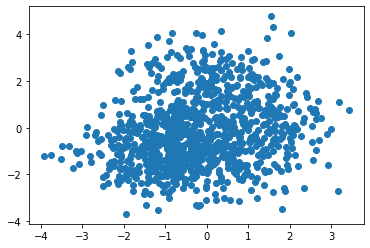

In [28]:
dif = DIFDensityEstimator(target_samples, 10)
with torch.no_grad():
    samples = dif.sample_model(1000)
    plt.scatter(samples[:,0].numpy(),samples[:,1].numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.44it/s, loss = 1.92537 ; device: cpu]


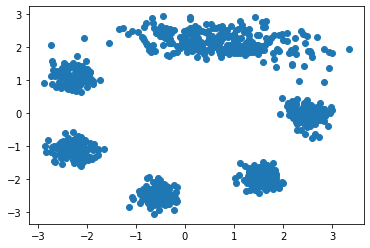

In [36]:
dif = DIFDensityEstimator(target_samples, 10, lr = 5e-3)
dif.train(100,1000)
with torch.no_grad():
    samples = dif.sample_model(1000)
    plt.scatter(samples[:,0].numpy(),samples[:,1].numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s, loss = 3.16782 ; device: cpu]


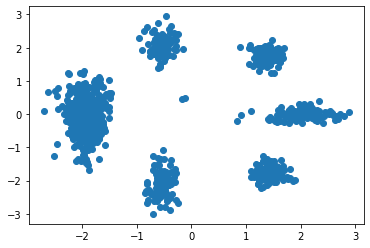

In [37]:
dif = DIFDensityEstimator(target_samples, 10,lr = 5e-3)
dif.train_(100,100)
with torch.no_grad():
    samples = dif.sample_model(1000)
    plt.scatter(samples[:,0].numpy(),samples[:,1].numpy())

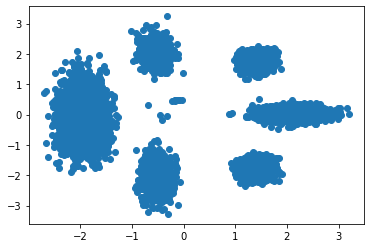

In [38]:

with torch.no_grad():
    samples = dif.sample_model(10000)
    plt.scatter(samples[:,0].numpy(),samples[:,1].numpy())